# Демо-экзамен по курсу "Прикладной анализ данных". Вариант 1

Выполнил: **НИЯУ МИФИ** Б23-215 **Донецков Андрей Дмитриевич**.

### Мой результат:

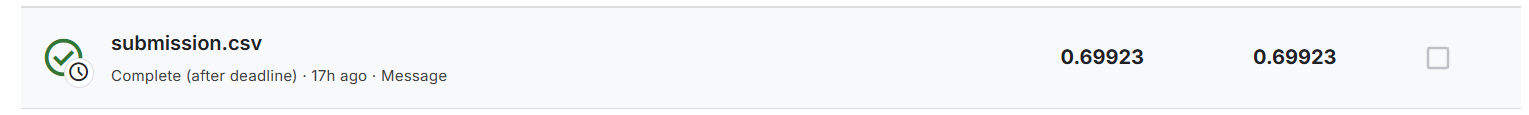

## 0. Описание задачи и данные

В 4 километрах от тихоокеанского берега Камчатки в бухте Вестник лежит остров Уташуд — часть Южно-Камчатского федерального заказника. На нем живут каланы, антуры, тюлени ларги, около 50 тысяч птиц десяти разных видов, включая  колонию топорика численностью 10 тыс. пар. В данной задаче нас интересуют двое обитатаелей острова – ларга и техоокеанская чайка, за которыми осуществляется наблюдение через фотоловушки в летний сезон.

На Уташуде находится репродуктивное лежбище тюленей-ларга  и одно из крупнейших на Камчатке поселений тихоокеанской чайки (4 тыс. пар). За 1 сезон наблюдения за этими животными может накопится более 1800 фотографий различного качества. Через эти фотографии инспекторы оценивают благополучие и численность животных.

Ссылка на соревнование и на данные: https://www.kaggle.com/competitions/where-are-the-seagulls

In [1]:
# Import libraries
# TODO

import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2


Небольшая инструкция как напрямую скачать данные с kaggle в Colab ноутбук: https://www.geeksforgeeks.org/python/how-to-import-kaggle-datasets-directly-into-google-colab/

In [2]:
import opendatasets as od

url = 'https://www.kaggle.com/competitions/where-are-the-seagulls'
od.download(url)

Skipping, found downloaded files in "./where-are-the-seagulls" (use force=True to force download)


In [3]:
train_images_path = "where-are-the-seagulls/data/train/images/"
train_labels_path = "where-are-the-seagulls/data/train/labels/"
test_images_path = "where-are-the-seagulls/data/test/images/"

train_images_path_array = [train_images_path + entry.name for entry in os.scandir(train_images_path) if entry.is_file()]
train_labels_path_array = [train_labels_path + entry.name for entry in os.scandir(train_labels_path) if entry.is_file()]
test_images_path_array = [test_images_path + entry.name for entry in os.scandir(test_images_path) if entry.is_file()]

In [4]:
combined_list = []

for label_path in train_labels_path_array:
    if os.path.getsize(label_path) > 0:
        temp_df = pd.read_csv(label_path, header=None, sep='\s+')
        temp_df['file_name'] = label_path
        combined_list.append(temp_df)

label_df = pd.concat(combined_list, ignore_index=True)
label_df.columns = ['label', 'x_center', 'y_center', 'width', 'height', 'file_name']
label_df = label_df[['file_name', 'label', 'x_center', 'y_center', 'width', 'height']]

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_469816/3944526556.py:5: SyntaxWarning: invalid escape sequence '\s'
  temp_df = pd.read_csv(label_path, header=None, sep='\s+')


## 1. Предварительное исследование данных

### Глянем на соотношения.

In [5]:
print(len(train_images_path_array), len(test_images_path_array))

500 99


> Можно и проще сделать вручную. Ну да ладно.

### Визуализирование рабочих фотографий.

In [6]:
# Посмотреть на изображения из папки
def look_images(imgage_path: str, resolutin: list) -> None:
    from random import sample

    num_samples = min(resolutin[0] * resolutin[1], len(imgage_path))
    sampled_paths = sample(imgage_path, num_samples)

    fig, axes = plt.subplots(resolutin[1], resolutin[0], figsize=(resolutin[0] * 4, resolutin[1] * 4))
    axes_flat = axes.flat

    for idx, ax in enumerate(axes_flat):
        if idx < num_samples:
            image = cv2.imread(sampled_paths[idx])
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image_rgb)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

Посмотрим на 15 изображений из **train**.

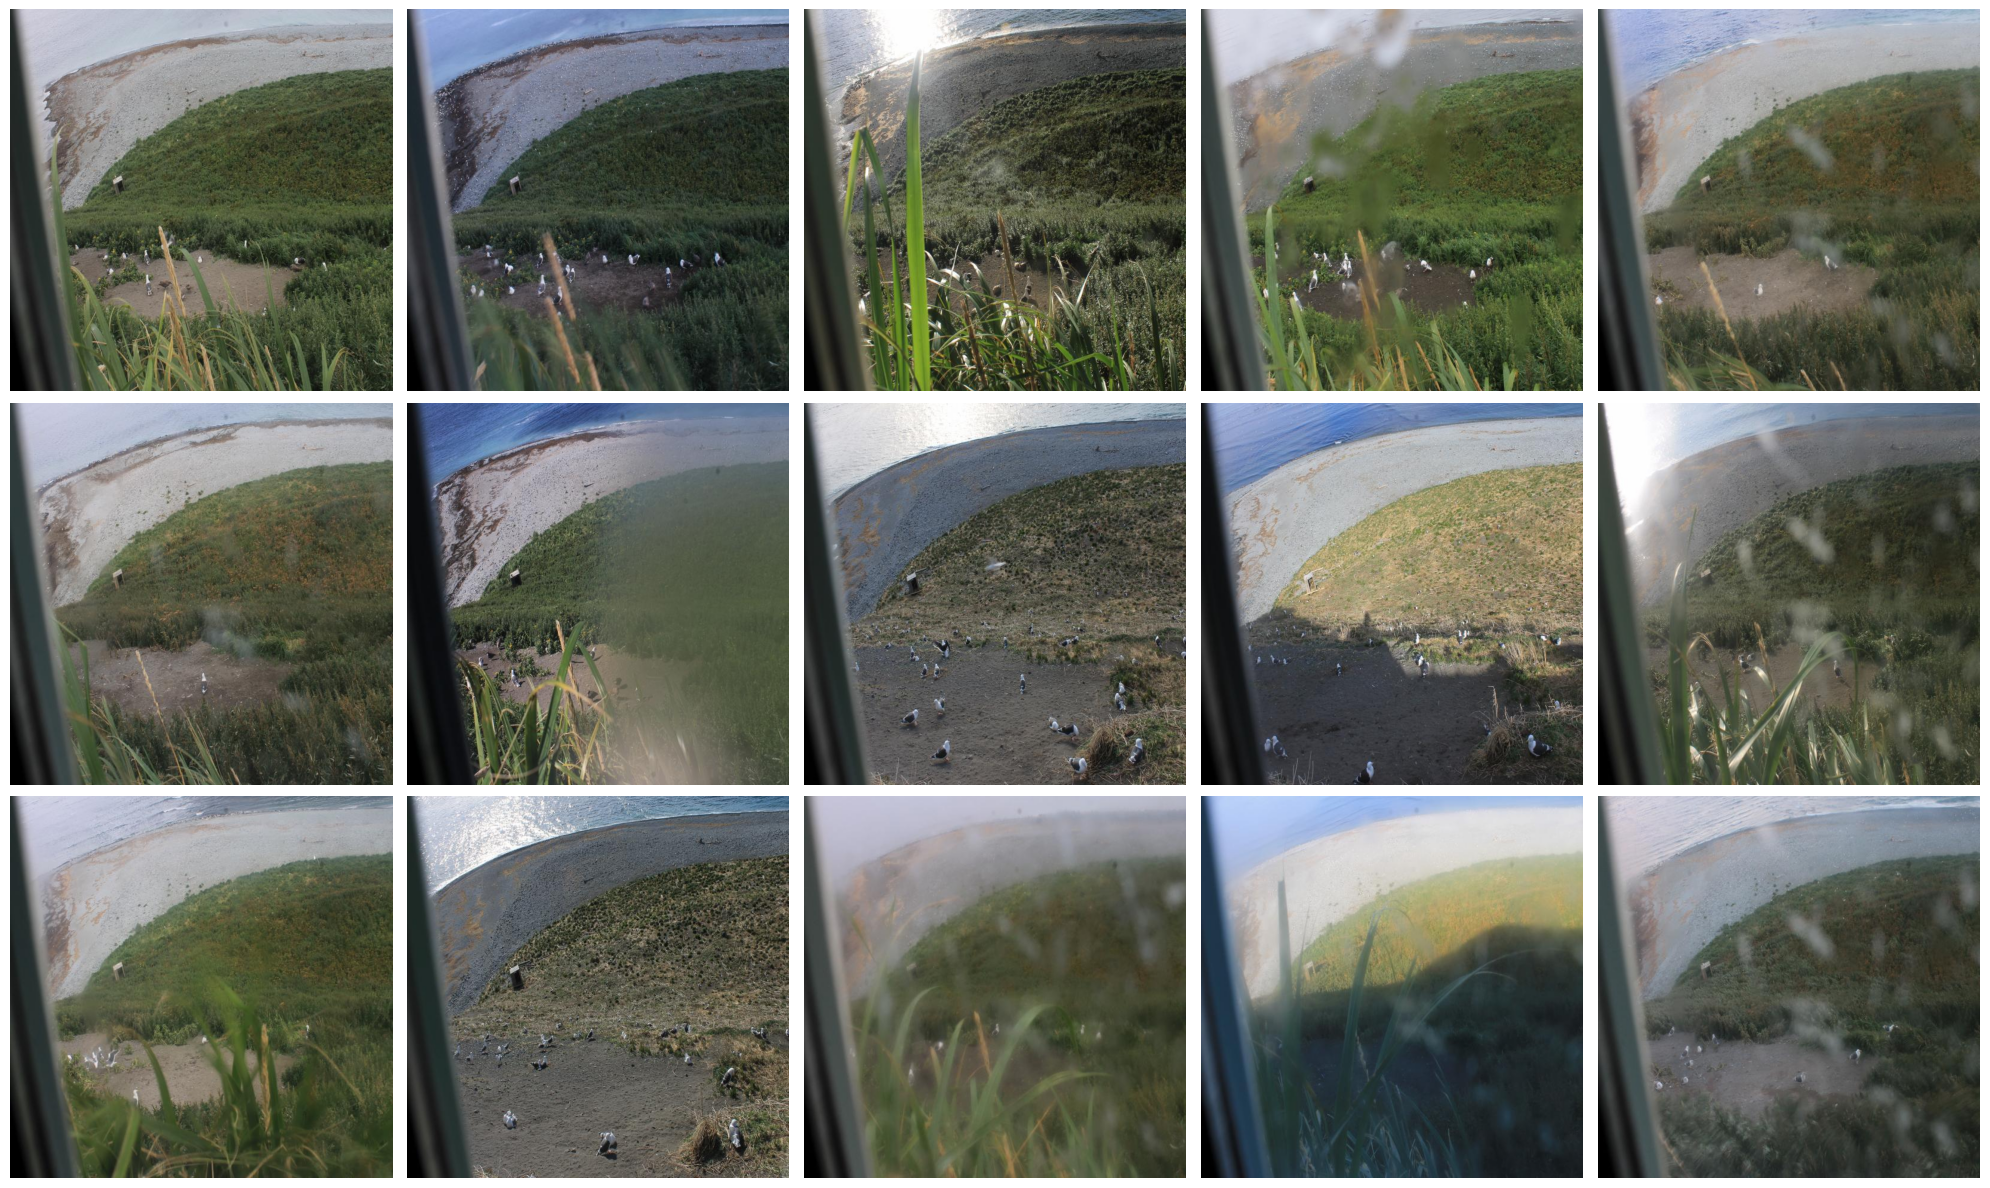

In [7]:
look_images(train_images_path_array, [5, 3])

Посмотрим на 15 изображений из **test**.

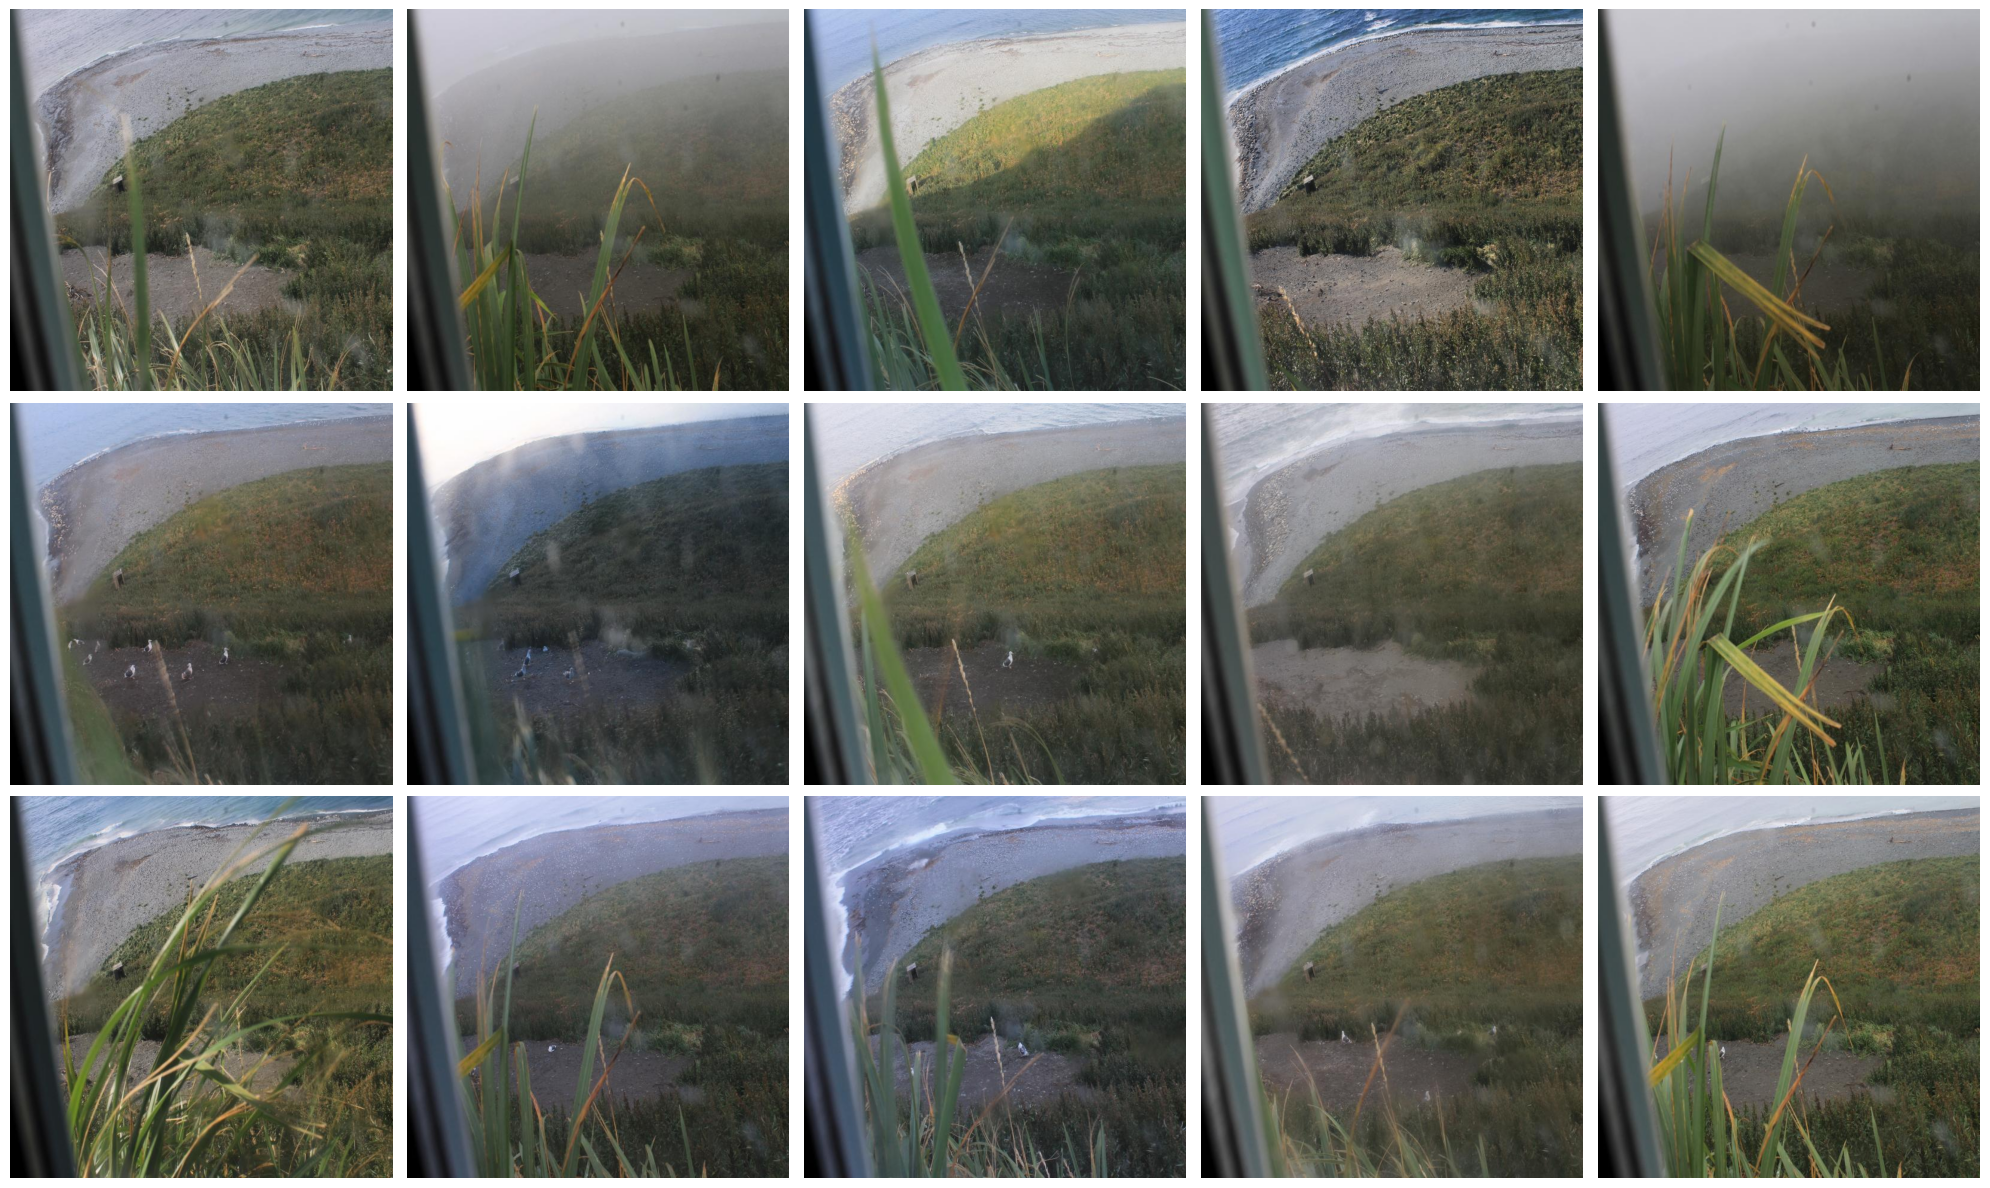

In [8]:
look_images(test_images_path_array, [5, 3])

1) Видно только чаек, где тюлени?
2) Похоже, что все фотографии были сделаны в одном и том же месте. Можно сразу отмести несколько вариантов изменения фотографий, например поворот и сдвиг.

In [9]:
label_df

file_name  label  x_center  \
0     where-are-the-seagulls/data/train/labels/20200...      0  0.178125   
1     where-are-the-seagulls/data/train/labels/20200...      0  0.178906   
2     where-are-the-seagulls/data/train/labels/20200...      0  0.290625   
3     where-are-the-seagulls/data/train/labels/20200...      0  0.364063   
4     where-are-the-seagulls/data/train/labels/20200...      0  0.406250   
...                                                 ...    ...       ...   
5381  where-are-the-seagulls/data/train/labels/20200...      0  0.657813   
5382  where-are-the-seagulls/data/train/labels/20200...      0  0.523438   
5383  where-are-the-seagulls/data/train/labels/20200...      0  0.371094   
5384  where-are-the-seagulls/data/train/labels/20200...      0  0.364063   
5385  where-are-the-seagulls/data/train/labels/20200...      0  0.766406   

      y_center     width    height  
0     0.648438  0.017188  0.032031  
1     0.678906  0.029687  0.029687  
2     0.697656  0.035937  0.028125  
3     0.663281  0.027344  0.037500  
4     0.771094  0.023438  0.066406  
...        ...       ...       ...  
5381  0.666406  0.022656  0.058594  
5382  0.721094  0.029687  0.050781  
5383  0.653125  0.021094  0.036719  
5384  0.697656  0.018750  0.026562  
5385  0.620313  0.025000  0.032813  

[5386 rows x 6 columns]

In [10]:
label_df["label"].unique()

array([0])

Значит разбираться будем только с чайками. Посмотрим на из расположение

<Figure size 640x480 with 0 Axes>

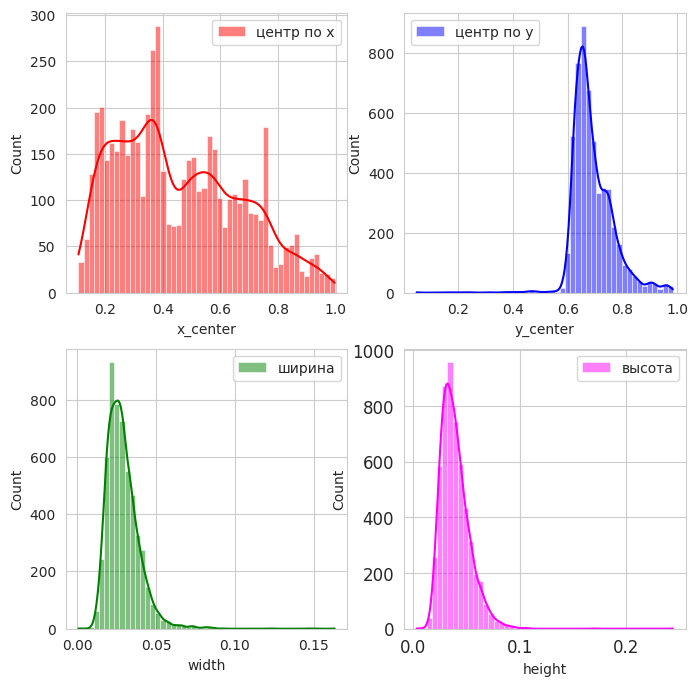

In [11]:
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

sns.histplot(label_df["x_center"], kde=True, bins=50, color="red", ax=ax[0, 0], label='центр по х')
sns.histplot(label_df["y_center"], kde=True, bins=50, color="blue", ax=ax[0, 1], label='центр по у')
sns.histplot(label_df["width"], kde=True, bins=50, color="green", ax=ax[1, 0], label='ширина')
sns.histplot(label_df["height"], kde=True, bins=50, color="magenta", ax=ax[1, 1], label='высота')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()


Видно, что объекты (в будующем просто - чайки) распологаются внизу изображений и примерно одного размера, что логично из того, что у нас изображения одного и тогоже места, а чайки поодали под окном. Посмоторим на исключения.

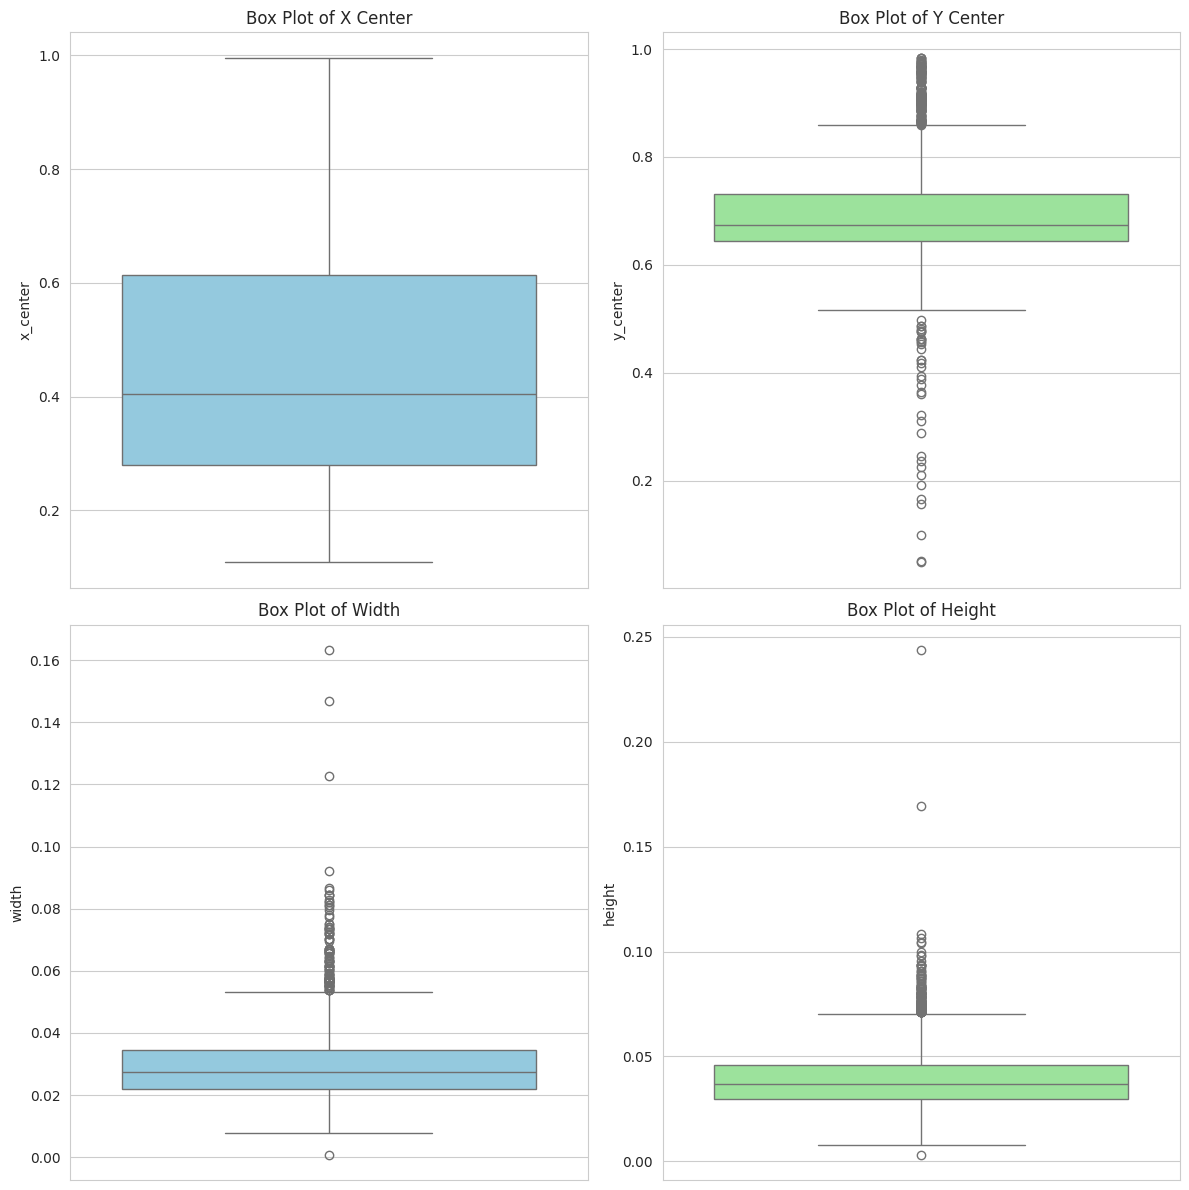

In [12]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
sns.boxplot(y=label_df["x_center"], color='skyblue')
plt.title('Box Plot of X Center')

plt.subplot(2, 2, 2)
sns.boxplot(y=label_df["y_center"], color='lightgreen')
plt.title('Box Plot of Y Center')

plt.subplot(2, 2, 3)
sns.boxplot(y=label_df["width"], color='skyblue')
plt.title('Box Plot of Width')

plt.subplot(2, 2, 4)
sns.boxplot(y=label_df["height"], color='lightgreen')
plt.title('Box Plot of Height')

plt.tight_layout()
plt.show()

Выглядит интересно. По x исключений нет, по y все хаотично, а из размеров двух чаех можно догадаться, что они сели прям у окна.

Но в общем можно ожидать хорошую обучаемость нейронной сети из за плюс-минус нормальгого распределения. Приступим.

## 2. Подготовка данных для обучения

Скучная часть. Ничего интересного.

In [13]:
# Скопировать данные для дальнейшей постобработки, плюс разделить данные на валидационную и тренировучную выборки
def dynamic_split(split_ratio=0.8) -> None:
    import random
    from sklearn.model_selection import train_test_split
    import shutil

    data_root = "data"
    old_dir = "where-are-the-seagulls/data"
    old_train_dir = os.path.join(old_dir, "train/")
    old_test_dir = os.path.join(old_dir, "test/")
    train_dir = os.path.join(data_root, "train/")
    val_dir = os.path.join(data_root, "val/")
    test_dir = os.path.join(data_root, "test/")

    shutil.rmtree(data_root, ignore_errors=True)
    os.makedirs(os.path.join(train_dir, "images"))
    os.makedirs(os.path.join(train_dir, "labels"))
    os.makedirs(os.path.join(val_dir, "images"))
    os.makedirs(os.path.join(val_dir, "labels"))

    old_image_dir = os.path.join(old_train_dir, "images")
    all_images = [f for f in os.listdir(old_image_dir) if f.endswith('.jpg')]
    random.shuffle(all_images)

    train_files, val_files = train_test_split(
        all_images, 
        train_size=split_ratio,
        random_state=random.randint(0, 1000)
    )

    def copy_files(file_list, target_dir):
        for img_file in file_list:
            src_img = os.path.join(old_train_dir, "images", img_file)
            dst_img = os.path.join(target_dir, "images", img_file)
            shutil.copy(src_img, dst_img)

            label_file = img_file.replace(".jpg", ".txt")
            src_label = os.path.join(old_train_dir, "labels", label_file)
            dst_label = os.path.join(target_dir, "labels", label_file)
            shutil.copy(src_label, dst_label)

    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)
    shutil.copytree(os.path.join(old_test_dir, "images"), os.path.join(test_dir, "images"))

In [14]:
# Искуственное увеличение выборки
def apply_albumentations_to_train_data(augmentation_pipeline, num_augmentations_per_image=1) -> None:
    from tqdm import tqdm
    
    data_root = "data"
    old_dir = "where-are-the-seagulls/data"
    train_dir = os.path.join(old_dir, "train/")
    augmented_train_dir = os.path.join(data_root, "train/")
    
    shutil.rmtree(augmented_train_dir, ignore_errors=True)
    os.makedirs(os.path.join(augmented_train_dir, "images"), exist_ok=True)
    os.makedirs(os.path.join(augmented_train_dir, "labels"), exist_ok=True)
    
    train_images_dir = os.path.join(train_dir, "images")
    train_labels_dir = os.path.join(train_dir, "labels")
    train_images = [f for f in os.listdir(train_images_dir) if f.endswith('.jpg')]
    
    for img_file in tqdm(train_images, desc="Applying augmentations"):
        img_path = os.path.join(train_images_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label_file = img_file.replace(".jpg", ".txt")
        label_path = os.path.join(train_labels_dir, label_file)
        bboxes = []
        class_labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, xc, yc, w, h = map(float, line.split())
                    bboxes.append([xc, yc, w, h])
                    class_labels.append(class_id)
        
        for aug_idx in range(num_augmentations_per_image):
            transformed = augmentation_pipeline(
                image=image,
                bboxes=bboxes,
                class_labels=class_labels
            )
            t_img = transformed['image']
            t_bboxes = transformed['bboxes']
            t_class_labels = transformed['class_labels']
            
            base_name = os.path.splitext(img_file)[0]
            new_img_name = f"{base_name}_aug{aug_idx}.jpg"
            new_label_name = f"{base_name}_aug{aug_idx}.txt"
            
            cv2.imwrite(
                os.path.join(augmented_train_dir, "images", new_img_name),
                cv2.cvtColor(t_img, cv2.COLOR_RGB2BGR)
            )

            with open(os.path.join(augmented_train_dir, "labels", new_label_name), 'w') as f:
                for cls, bbox in zip(t_class_labels, t_bboxes):
                    f.write(f"{int(cls)} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")


def get_augmentation_pipeline():
    import albumentations as A
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.4),
        A.RandomRain(drop_width=1, blur_value=2, p=0.3),
        A.GlassBlur(max_delta=2, p=0.2),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.4),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.3),
        A.GaussNoise(p=0.3),
        A.ImageCompression(p=0.2),
    ], bbox_params=A.BboxParams(
        format='yolo',
        label_fields=['class_labels']
    ))

In [15]:
dynamic_split(split_ratio=0.8)

pipeline = get_augmentation_pipeline()
apply_albumentations_to_train_data(
    augmentation_pipeline=pipeline,
    num_augmentations_per_image=4
)

Applying augmentations: 100%|██████████| 500/500 [00:21<00:00, 23.47it/s]


## 3. Реализация модели, её обучение и получение результатов

In [22]:
from ultralytics import YOLO

model = YOLO("yolo11x.pt")

In [23]:
results = model.train(data="dataset.yaml", epochs=100)
results = model.val()

New https://pypi.org/project/ultralytics/8.3.165 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24081MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=Fals

train: Scanning /home/andredon/projects/ADA/Homework_final/data/train/labels.cache... 2000 images, 128 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]

train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug0.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug1.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug2.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5_aug3.jpg: 2 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68_aug0.jpg: 3 duplicate labels removed
train: /home/andredon/projects/ADA/Homework_final/data/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68_aug1.jpg: 3 duplicate labels removed
train: /home/and

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1723.3±306.9 MB/s, size: 59.5 KB)


val: Scanning /home/andredon/projects/ADA/Homework_final/data/val/labels.cache... 100 images, 9 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

val: /home/andredon/projects/ADA/Homework_final/data/val/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed


Plotting labels to /home/andredon/projects/ADA/runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/andredon/projects/ADA/runs/detect/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.9G      2.428      1.903      1.258        218        640: 100%|██████████| 125/125 [00:28<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]

                   all        100       1009     0.0158      0.171    0.00823    0.00333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      15.5G      2.392      1.576       1.22        177        640: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.24it/s]

                   all        100       1009      0.671      0.543      0.581      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.5G      2.352      1.567        1.2        297        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.45it/s]

                   all        100       1009      0.513      0.548      0.465      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      15.6G      2.311      1.508       1.19        220        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.68it/s]

                   all        100       1009      0.667      0.545      0.585      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      15.6G      2.221      1.415      1.168        281        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.62it/s]

                   all        100       1009      0.696      0.601      0.658       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      15.4G      2.225      1.405      1.158        153        640: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

                   all        100       1009      0.805      0.683       0.77      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      15.7G      2.192      1.386       1.15        231        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

                   all        100       1009      0.812      0.745      0.829      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      15.7G      2.149      1.332      1.133        266        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

                   all        100       1009      0.832      0.728      0.804       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      15.7G      2.145      1.309      1.128        191        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.859      0.727      0.829      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      15.4G      2.111      1.273      1.121        209        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

                   all        100       1009      0.848      0.761       0.85      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      15.6G      2.098      1.268      1.121        191        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.65it/s]

                   all        100       1009      0.828       0.72      0.823      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      15.7G       2.09      1.262      1.113        237        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        100       1009      0.874      0.751      0.845      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      15.7G      2.055      1.214      1.102        271        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.69it/s]

                   all        100       1009      0.801      0.745       0.82      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      15.4G      2.062       1.21        1.1        221        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        100       1009      0.864      0.723      0.854      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      15.7G      2.046      1.196      1.101        138        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        100       1009      0.859      0.769      0.867      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      15.6G      2.032      1.186      1.101        145        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all        100       1009      0.829      0.786      0.863      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      15.6G      2.035      1.187      1.091        175        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.70it/s]

                   all        100       1009      0.836      0.762      0.852      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      15.4G      2.014      1.184      1.094        166        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

                   all        100       1009      0.822      0.777      0.849      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      15.6G      1.981      1.147      1.074        187        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.67it/s]

                   all        100       1009      0.851      0.793      0.863      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      15.7G      1.985      1.141      1.084        290        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

                   all        100       1009       0.86      0.816       0.89      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      15.6G      1.969      1.127       1.08        328        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.888       0.81      0.897      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      15.4G      1.974      1.124      1.073        171        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.907      0.823      0.899       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      15.6G      1.958      1.104       1.07        201        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.72it/s]

                   all        100       1009      0.836       0.78      0.865      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      15.7G      1.948      1.104      1.072        298        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.871      0.836      0.898      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      15.7G      1.933      1.089      1.071        168        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.891      0.822      0.899      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      15.5G      1.917      1.084      1.065        234        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.886      0.805      0.895      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      15.6G      1.921      1.088       1.06        293        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        100       1009      0.913      0.824      0.905      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      15.7G      1.916      1.067      1.067        168        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.899      0.842      0.909      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      15.6G      1.891      1.055      1.053        236        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.896      0.842       0.91      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      15.5G      1.874      1.036      1.055        277        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.896      0.827       0.91      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      15.7G      1.865      1.026      1.051        257        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

                   all        100       1009      0.904      0.877      0.927      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      15.7G      1.887      1.042       1.06        190        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.908      0.842      0.922      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      15.6G      1.871      1.037      1.055        189        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.899      0.836      0.915      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      15.4G      1.852      1.018      1.041        235        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.911      0.841      0.922       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      15.6G      1.834      1.002      1.045        243        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.73it/s]

                   all        100       1009      0.922      0.858      0.932      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      15.7G      1.854     0.9991      1.046        147        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.928      0.837      0.929      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.6G      1.836     0.9967      1.043        191        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.918      0.854      0.933      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      15.5G      1.818     0.9786      1.038        214        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.75it/s]

                   all        100       1009      0.909      0.868      0.934      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      15.7G      1.825     0.9869      1.037        205        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.931      0.867      0.931      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      15.7G      1.813     0.9669      1.028        204        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.911      0.862      0.934       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      15.6G      1.805     0.9708      1.038        158        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.923      0.874      0.941      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      15.4G      1.786     0.9449      1.025        243        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        100       1009      0.907      0.856      0.928      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      15.7G      1.785     0.9496      1.022        207        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.914      0.892      0.942      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      15.7G      1.759     0.9273      1.022        199        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.933      0.857      0.929      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      15.6G      1.798     0.9636      1.036        304        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        100       1009      0.918      0.873      0.939      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      15.5G      1.758     0.9246       1.02        227        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.931      0.885      0.946      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      15.7G      1.768     0.9342      1.014        199        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        100       1009      0.929      0.889      0.944      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      15.7G       1.74     0.9094      1.014        171        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.939      0.883      0.946      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      15.6G      1.725     0.8996      1.015        239        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.933      0.893      0.951      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      15.5G      1.733     0.9103      1.017        158        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.941      0.884      0.951       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      15.7G      1.722     0.9053      1.005        213        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.932      0.884      0.945      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      15.6G      1.701     0.8858      1.008        292        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.935      0.891      0.954      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      15.7G      1.697     0.8813      1.005        210        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.928      0.885      0.952      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      15.4G      1.684     0.8751     0.9963        262        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.88it/s]

                   all        100       1009      0.929      0.894      0.948      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      15.7G      1.693     0.8815      1.007        202        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        100       1009      0.925      0.907      0.956      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      15.6G      1.681     0.8707      1.005        268        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        100       1009      0.937      0.903      0.957      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      15.7G       1.67     0.8722      1.001        250        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        100       1009      0.938      0.889      0.957       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      15.5G      1.668     0.8616     0.9948        280        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.933       0.91      0.958      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      15.7G      1.644     0.8483     0.9946        156        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.956      0.894      0.962       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      15.7G      1.636     0.8403     0.9907        243        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        100       1009      0.941      0.911      0.957      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      15.7G       1.64     0.8434     0.9942        175        640: 100%|██████████| 125/125 [00:27<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.939      0.908      0.966      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      15.4G      1.632     0.8357      0.985        238        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.92it/s]

                   all        100       1009      0.935      0.918      0.965      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      15.7G       1.61     0.8251     0.9835        226        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.945      0.911      0.964      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      15.6G      1.592     0.8114     0.9821        222        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.949      0.904      0.963      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      15.6G      1.588      0.816     0.9843        194        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.934      0.919      0.964      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      15.5G      1.573     0.7986     0.9773        218        640: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        100       1009       0.95      0.914       0.97      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      15.7G      1.582     0.7986     0.9786        240        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.945      0.913      0.966      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      15.7G      1.576     0.8076     0.9821        262        640: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.946      0.916      0.969       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      15.7G      1.552     0.7773     0.9693        187        640: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.939      0.932      0.975        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      15.5G      1.549     0.7902     0.9678        323        640: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.939      0.923      0.967      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      15.7G      1.523     0.7627     0.9619        235        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.77it/s]

                   all        100       1009      0.945      0.926       0.97      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      15.6G      1.525     0.7693     0.9648        186        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        100       1009      0.952      0.925      0.971       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      15.6G      1.501     0.7592     0.9543        181        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        100       1009      0.948      0.929      0.972      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      15.6G      1.522     0.7724     0.9666        296        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.961       0.93      0.978      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      15.6G      1.495     0.7482     0.9531        199        640: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.947      0.935      0.974      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      15.6G      1.494     0.7509     0.9497        265        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.948       0.93      0.974      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      15.7G      1.464     0.7313     0.9517        234        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        100       1009      0.966      0.924      0.977      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      15.4G      1.483     0.7443     0.9569        163        640: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.86it/s]

                   all        100       1009      0.951      0.933      0.975      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      15.7G      1.461     0.7362     0.9493        291        640: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.80it/s]

                   all        100       1009      0.956      0.931      0.977       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      15.6G      1.451     0.7312      0.945        312        640: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.953      0.939      0.978      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      15.7G      1.445      0.724     0.9449        235        640: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.965      0.935      0.979      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      15.5G       1.43     0.7177     0.9393        193        640: 100%|██████████| 125/125 [00:27<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        100       1009      0.961      0.936       0.98      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      15.6G      1.437     0.7256      0.944        175        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        100       1009      0.945      0.943      0.977      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      15.7G        1.4     0.7054      0.936        236        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        100       1009      0.952      0.944      0.978      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      15.7G      1.405     0.7009     0.9359        251        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        100       1009      0.961      0.943       0.98      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      15.5G      1.405      0.702     0.9352        244        640: 100%|██████████| 125/125 [00:27<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.957      0.937      0.978      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      15.7G      1.399     0.7056     0.9357        231        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.956      0.952      0.981      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      15.7G      1.399     0.6997     0.9343        343        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.958      0.942      0.982      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      15.7G      1.376       0.69     0.9313        211        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        100       1009      0.962      0.943      0.983       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      15.4G      1.364     0.6787      0.926        193        640: 100%|██████████| 125/125 [00:26<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.87it/s]

                   all        100       1009      0.966      0.943      0.982      0.661


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      15.6G       1.36     0.6782     0.9556        182        640: 100%|██████████| 125/125 [00:27<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.964      0.939       0.98      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      15.6G      1.318     0.6529      0.944        121        640: 100%|██████████| 125/125 [00:27<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.83it/s]

                   all        100       1009      0.971      0.938      0.981       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      15.6G      1.315     0.6531     0.9476        206        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.85it/s]

                   all        100       1009      0.965      0.943      0.982      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      15.5G      1.304      0.652     0.9401        138        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.962      0.945      0.981      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      15.7G      1.289     0.6373     0.9377        240        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.78it/s]

                   all        100       1009      0.968      0.944      0.981      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      15.7G      1.281     0.6311     0.9366        182        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

                   all        100       1009       0.97      0.947      0.982      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      15.6G      1.277      0.635     0.9367        154        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.79it/s]

                   all        100       1009      0.975      0.935      0.982      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      15.5G      1.271     0.6329     0.9365        124        640: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.81it/s]

                   all        100       1009      0.967      0.942      0.983      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      15.7G      1.257     0.6282     0.9264        152        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.76it/s]

                   all        100       1009      0.969      0.942      0.983      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      15.7G      1.266     0.6307     0.9354        162        640: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.82it/s]

                   all        100       1009      0.968      0.944      0.985      0.687



100 epochs completed in 0.794 hours.
Optimizer stripped from /home/andredon/projects/ADA/runs/detect/train5/weights/last.pt, 114.4MB
Optimizer stripped from /home/andredon/projects/ADA/runs/detect/train5/weights/best.pt, 114.4MB

Validating /home/andredon/projects/ADA/runs/detect/train5/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24081MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.74it/s]


                   all        100       1009      0.968      0.943      0.985      0.687
Speed: 0.1ms preprocess, 3.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /home/andredon/projects/ADA/runs/detect/train5
Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24081MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4033.4±1026.3 MB/s, size: 57.6 KB)


val: Scanning /home/andredon/projects/ADA/Homework_final/data/val/labels.cache... 100 images, 9 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

val: /home/andredon/projects/ADA/Homework_final/data/val/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]


                   all        100       1009      0.967      0.945      0.985      0.686
Speed: 0.6ms preprocess, 6.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /home/andredon/projects/ADA/runs/detect/train52


In [24]:
results = model.predict("where-are-the-seagulls/data/test/images")


image 1/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200928_150507_01_JPG.rf.109359154a680b75a67dce1e82062e55.jpg: 640x640 (no detections), 6.9ms
image 2/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200928_160525_01_JPG.rf.50f3289f065a9a4f5372ffa3df9e7265.jpg: 640x640 (no detections), 6.9ms
image 3/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200928_180600_01_JPG.rf.df87e688ee0e009c3a06572a4997cf81.jpg: 640x640 (no detections), 6.9ms
image 4/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200929_081017_01_JPG.rf.c0e8134223d6ed61ac5187cc29495bd9.jpg: 640x640 (no detections), 6.9ms
image 5/99 /home/andredon/projects/ADA/Homework_final/where-are-the-seagulls/data/test/images/20200929_091035_01_JPG.rf.cc0f7b275eb3a5dd680df0011fa46c36.jpg: 640x640 (no detections), 6.9ms
image 6/99 /home/andredon/projects/ADA/Homework_final/

In [25]:
detections = []
for result in results:
    file_name = os.path.basename(result.path)
    
    bbox_str = ""
    
    if len(result.boxes) > 0:
        boxes_norm = result.boxes.xywhn.cpu().numpy()
        class_ids = result.boxes.cls.cpu().numpy().astype(int)
        
        box_strings = []
        for i in range(len(boxes_norm)):
            box = boxes_norm[i]
            box_strings.append(f"{class_ids[i]} {box[0]:.2f} {box[1]:.2f} {box[2]:.2f} {box[3]:.2f}")
        bbox_str = " ".join(box_strings)
    else:
        bbox_str = "-1"
    
    detections.append({
        "filename": file_name,
        "bbox": bbox_str
    })

df = pd.DataFrame(detections)
df

filename bbox
0   20200928_150507_01_JPG.rf.109359154a680b75a67d...   -1
1   20200928_160525_01_JPG.rf.50f3289f065a9a4f5372...   -1
2   20200928_180600_01_JPG.rf.df87e688ee0e009c3a06...   -1
3   20200929_081017_01_JPG.rf.c0e8134223d6ed61ac51...   -1
4   20200929_091035_01_JPG.rf.cc0f7b275eb3a5dd680d...   -1
..                                                ...  ...
94  20201011_163823_01_JPG.rf.e2a5508980ce1a7009ec...   -1
95  20201011_173839_01_JPG.rf.078741d81a9f4e1427dd...   -1
96  20201012_074301_01_JPG.rf.aeea80a57963913c15a9...   -1
97  20201012_084317_01_JPG.rf.1628fe9f8845551f938c...   -1
98  20201012_085146_01_JPG.rf.17b44f92fa8cfa93ea1c...   -1

[99 rows x 2 columns]

In [26]:
df = df.reset_index()
df.to_csv("submission.csv", index=False)

In [27]:
!kaggle competitions submit -c where-are-the-seagulls -f submission.csv -m "Message"

100%|██████████████████████████████████████| 9.11k/9.11k [00:00<00:00, 20.5kB/s]
Successfully submitted to Where are the seagulls?